## CHAPTER 7: RNN을 사용한 문장 생성

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

### 7.1 언어 모델을 사용한 문장 생성

#### 7.1.2 문장 생성 구현

In [2]:
import sys; sys.path.append('exam_code')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1,1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            if skip_ids is None or sampled not in skip_ids:
                x = sampled
                word_ids.append(int(x))
        return word_ids

In [10]:
import sys; sys.path.append('exam_code')
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size  = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('exam_code/ch06/Rnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문자 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you would n't impact of all this going to be the famous length.
 some of most washington mr. gates and the racked pulled mr. lesko 's appointment.
 i do dangerous that there was n't no do with the quantity of its course soon.
 you 'd write hazards at the department 's fund of the embassy a slower wage.
 georgia-pacific 's largest insurance concern reported operating profit for higher revenue.
 september some of one purchased paid sept. to slow to a factory.
 mr. stevens said talks with bankruptcy commitment to hold up wind said gerald


#### 7.2.4 덧셈 데이터셋

In [11]:
import sys; sys.path.append('exam_code')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


### 7.3 seq2seq 구현

#### 7.3.1 Encoder 클래스
<img src=attachment:image.png width=200px></img>
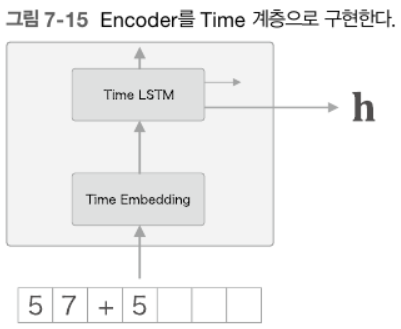

In [ ]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b  = np.zeros(4*H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm  = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads  = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

#### 7.3.2 Decoder 클래스

<img src=attachment:image.png width=250px></img>
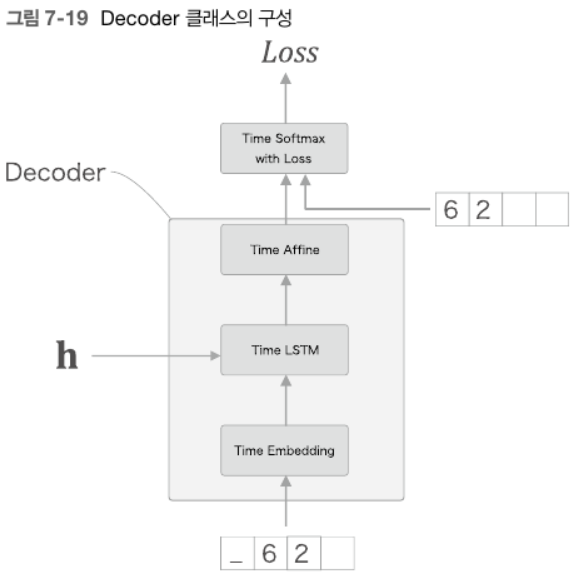

In [12]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b  = np.zeros(4*H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed  = TimeEmbedding(embed_W)
        self.lstm   = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self,embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads  += layer.grads
        
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1)
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        
        return sampled

#### 7.3.3 seq2seq 클래스

In [14]:
import sys; sys.path.append('exam_code')
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads  = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        
        h     = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss  = self.softmax(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dscore = self.softmax.backward(dout)
        dh     = self.decoder.backward(dscore)
        dout   = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h       = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

#### 7.3.4 seq2seq 평가

In [18]:
import sys; sys.path.append('exam_code'); sys.path.append('exam_code/ch07')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size   = len(char_to_id)
wordvec_size = 16
hidden_size  = 128
batch_size   = 128
max_epoch    = 25
max_grad     = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, 
                batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc*100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

Q 77+85  
T 162 
X 156 
---
Q 975+164
T 1139
X 1107
---
Q 582+84 
T 666 
X 661 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 412 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1009
---
Q 830+597
T 1427
X 1411
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 227 
---
검증 정확도 4.300%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 1.00
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 1.00
| 에폭 9 |  반복 101 / 351 | 시간 2[s] | 손실 1.02
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 1.01
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 1.02
| 에폭 9 |  반복 201 / 351 | 시간 5[s] | 손실 1.01
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 1.00
| 에폭 9 |  반복 261 / 351 | 시간 7[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 301 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 321 / 351 |

| 에폭 16 |  반복 181 / 351 | 시간 5[s] | 손실 0.89
| 에폭 16 |  반복 201 / 351 | 시간 6[s] | 손실 0.88
| 에폭 16 |  반복 221 / 351 | 시간 6[s] | 손실 0.89
| 에폭 16 |  반복 241 / 351 | 시간 7[s] | 손실 0.89
| 에폭 16 |  반복 261 / 351 | 시간 8[s] | 손실 0.86
| 에폭 16 |  반복 281 / 351 | 시간 8[s] | 손실 0.83
| 에폭 16 |  반복 301 / 351 | 시간 9[s] | 손실 0.84
| 에폭 16 |  반복 321 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 341 / 351 | 시간 10[s] | 손실 0.91
Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1128
---
Q 582+84 
T 666 
X 672 
---
Q 8+155  
T 163 
X 172 
---
Q 367+55 
T 422 
X 427 
---
Q 600+257
T 857 
X 862 
---
Q 761+292
T 1053
X 1062
---
Q 830+597
T 1427
X 1424
---
Q 26+838 
T 864 
X 859 
---
Q 143+93 
T 236 
X 252 
---
검증 정확도 6.200%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.89
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.85
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.87
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.88
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.85
| 에폭 17 |  반복 101 / 351 | 시간 2[s] | 손실 0.89
| 에폭 17 |  반복 121 / 351 | 시간 3[s] | 손실 0.88
| 에폭 17

검증 정확도 8.500%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.77
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.80
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.77
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.77
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.81
| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.80
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.79
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.80
| 에폭 24 |  반복 201 / 351 | 시간 5[s] | 손실 0.77
| 에폭 24 |  반복 221 / 351 | 시간 6[s] | 손실 0.79
| 에폭 24 |  반복 241 / 351 | 시간 7[s] | 손실 0.78
| 에폭 24 |  반복 261 / 351 | 시간 7[s] | 손실 0.78
| 에폭 24 |  반복 281 / 351 | 시간 8[s] | 손실 0.78
| 에폭 24 |  반복 301 / 351 | 시간 8[s] | 손실 0.79
| 에폭 24 |  반복 321 / 351 | 시간 9[s] | 손실 0.82
| 에폭 24 |  반복 341 / 351 | 시간 10[s] | 손실 0.79
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 669 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 421 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1055
---
Q 8

### 7.4 seq2seq 개선

#### 7.4.1 입력 데이터 반전(Reverse)

<img src=attachment:image.png width=300px></img>

```
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
```
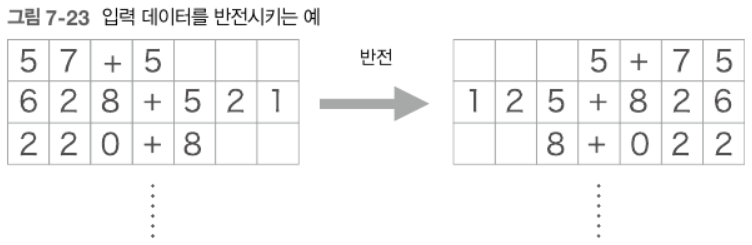

#### 7.4.2 엿보기(Peeky)

중요한 정보가 담긴 Encoder의 출력 h를 Decoder의 다른 계층에도 전해주는 방식.

<img src=attachment:image.png width=400px></img>
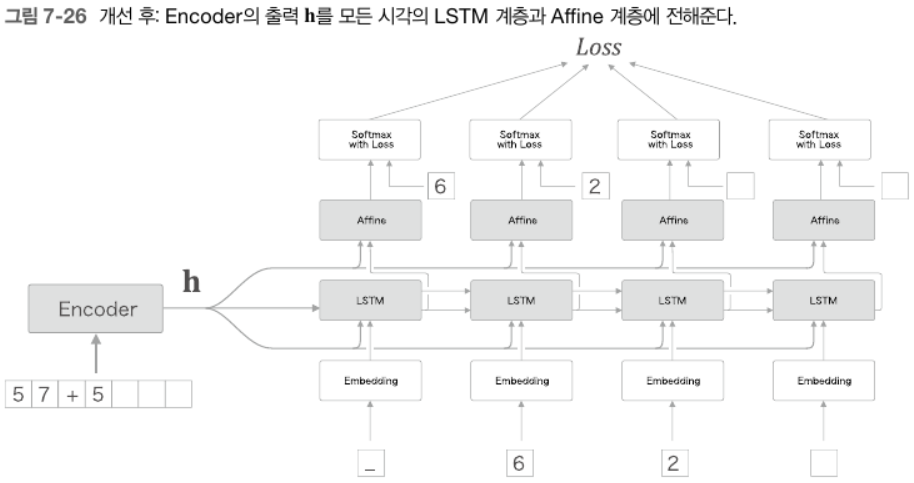

In [13]:
import sys; sys.path.append('exam_code');
from common.time_layers import *

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(H+D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b  = np.zeros(4*H).astype('f')
        affine_W = (rn(H+H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed  = TimeEmbedding(embed_W)
        self.lstm   = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads  += layer.grads
        self.cache = None
        
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape
        
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N,T,H)
        out = np.concatenate((hs,out), axis=2)
        
        out = self.lstm.forward(out)
        out = np.concatenate((hs,out), axis=2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache
        
        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, H]
        dout = self.lstm.backward(dout)
        dout, dhs1 = dout[:, :, H:], dout[:, :, H]
        dout = self.embed.backward(dout)
        
        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        H = h.shape[1]
        peeky_h = h.reshape(1,1,H)
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1)
            out = self.embed.forward(x)
            
            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        
        return sampled

In [14]:
import sys; sys.path.append('exam_code'); sys.path.append('exam_code/ch07')
from seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads  = self.encoder.grads + self.decoder.grads

In [16]:
import sys; sys.path.append('exam_code'); sys.path.append('exam_code/ch07')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size   = len(char_to_id)
wordvec_size = 16
hidden_size  = 128
batch_size   = 128
max_epoch    = 25
max_grad     = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, 
                batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc*100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.49
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.84
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.80
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.77
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.75
| 에폭 1 |  반복 241 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.73
| 에폭 1 |  반복 321 / 351 | 시간 9[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 10[s] | 손실 1.73
Q 77+85  
T 162 
X 107 
---
Q 975+164
T 1139
X 1011
---
Q 582+84 
T 666 
X 103 
---
Q 8+155  
T 163 
X 101 
---
Q 367+55 
T 422 
X 103 
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1011
---
Q 26+83

Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1037
---
Q 830+597
T 1427
X 1437
---
Q 26+838 
T 864 
X 869 
---
Q 143+93 
T 236 
X 231 
---
검증 정확도 12.480%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.70
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.70
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.70
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.70
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.70
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.69
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 0.69
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.68
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 0.68
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 0.67
| 에폭 9 |  반복 201 / 351 | 시간 6[s] | 손실 0.68
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 0.67
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 0.67
| 에폭 9 |  반복 261 / 351 | 시간 7[s] | 손실 0.67
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 0.66
| 에폭 9 |  반복 301 / 351 | 시간 9[s] | 손실 0.66
| 에폭 9 |  반복 321 / 351 

| 에폭 16 |  반복 161 / 351 | 시간 4[s] | 손실 0.43
| 에폭 16 |  반복 181 / 351 | 시간 5[s] | 손실 0.43
| 에폭 16 |  반복 201 / 351 | 시간 6[s] | 손실 0.42
| 에폭 16 |  반복 221 / 351 | 시간 6[s] | 손실 0.43
| 에폭 16 |  반복 241 / 351 | 시간 7[s] | 손실 0.44
| 에폭 16 |  반복 261 / 351 | 시간 8[s] | 손실 0.43
| 에폭 16 |  반복 281 / 351 | 시간 8[s] | 손실 0.42
| 에폭 16 |  반복 301 / 351 | 시간 9[s] | 손실 0.43
| 에폭 16 |  반복 321 / 351 | 시간 9[s] | 손실 0.45
| 에폭 16 |  반복 341 / 351 | 시간 10[s] | 손실 0.44
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1048
---
Q 830+597
T 1427
X 1429
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 31.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.41
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.41
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.41
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.42
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.42
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.42
| 에폭 1

검증 정확도 70.680%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.18
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.18
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.18
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.18
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.17
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.18
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.17
| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.17
| 에폭 24 |  반복 161 / 351 | 시간 5[s] | 손실 0.17
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.18
| 에폭 24 |  반복 201 / 351 | 시간 6[s] | 손실 0.18
| 에폭 24 |  반복 221 / 351 | 시간 7[s] | 손실 0.17
| 에폭 24 |  반복 241 / 351 | 시간 7[s] | 손실 0.18
| 에폭 24 |  반복 261 / 351 | 시간 8[s] | 손실 0.18
| 에폭 24 |  반복 281 / 351 | 시간 8[s] | 손실 0.17
| 에폭 24 |  반복 301 / 351 | 시간 9[s] | 손실 0.17
| 에폭 24 |  반복 321 / 351 | 시간 10[s] | 손실 0.16
| 에폭 24 |  반복 341 / 351 | 시간 10[s] | 손실 0.16
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 164 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
X 1054
---
Q